In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np 
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_math = pd.read_excel('stud_math.xlsx')

In [102]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,кол-во,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,1,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,1,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,1,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,1,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,1,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,1,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,1,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,1,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,1,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,1,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
кол-во                 395 non-null int64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              387 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-n

# Первичная обработка данных

In [103]:
#создаем унииверсальные функции:

def info_columns(column):#по каждой колонке в таблице выведем уникальные значения и количество пропусков
    print('Уникальные значения:','\n',column.value_counts(),'\n',
          'Пустые значения (кол-во):',column.isnull().sum(),'\n',
          'Пустые значения (%):',round(column.isnull().sum()/column.isnull().count()*100,1))

def show_histo(column):#построим гистограмму для определенной колонки
    fig, ax = plt.subplots(figsize = (13,4))
    column.hist()
    plt.show()
    
def get_boxplot(column): #построим диаграмму размаха с "усами" для определенной колонки
    fig,ax=plt.subplots(figsize=(13,4))
    sns.boxplot(x=column,y='score', data=stud_math)
    plt.show

def limits(column):#определяем перцентили и границы выбросов для определенной колонки
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}].".format(low,up))
    for i in column:
        if i <= low or i >= up:
            print('Имеются выбросы')
            break
            
def get_stat_dif(column):#определяем колонки с статистически значимыми отклонениями
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [104]:
#переименуем некоторые колонки, для однозначного понимания какие значения хранятся в них
#(пример:sex_male, если значение 1 значит мужчина,если 0 значит женщина):

stud_math = stud_math.rename(columns={'sex': 'sex_male',
                                      'school': 'school_number',
                                      'address':'urbanite', 
                                      'famsize': 'famsize_more3',
                                      'Pstatus': 'Pstatus_together',
                                      'studytime, granular': 'granular_studytime'})

#приведем к числовому формату номинативные переменные для анализа:

for column in ['schoolsup','famsup','paid','activities',
               'nursery','higher','internet','romantic']:
    stud_math[column]=stud_math[column].apply(lambda x:0 if x=='no' else 1 if x=='yes' else x)

stud_math.sex_male=stud_math.sex_male.apply(lambda x: 1 if x=='M' else 0 if x=='F' else x)
stud_math.school_number=stud_math.school_number.apply(lambda x: 1 if x=='GP' else 2 if x=='MS' else x)
stud_math.urbanite=stud_math.urbanite.apply(lambda x: 1 if x=='U' else 0 if x=='R' else x)
stud_math.famsize_more3=stud_math.famsize_more3.apply(lambda x: 1 if x=='GT3' else 0 if x=='LE3' else x)
stud_math.Pstatus_together=stud_math.Pstatus_together.apply(lambda x: 1 if x=='T' else 0 if x=='A' else x)

for column in ['Mjob','Fjob']:
    stud_math[column]=stud_math[column].apply(lambda x: 1 if x=='teacher'
                                              else 2 if x=='health'
                                              else 3 if x=='services'
                                              else 4 if x=='at_home'
                                              else 5 if x=='other'
                                              else x)
stud_math.reason=stud_math.reason.apply(lambda x: 1 if x=='home'
                                              else 2 if x=='reputation'
                                              else 3 if x=='course'
                                              else 4 if x=='other'
                                              else x)
stud_math.guardian=stud_math.guardian.apply(lambda x: 1 if x=='mother'
                                              else 2 if x=='father'
                                              else 3 if x=='other'
                                              else x)

display(stud_math.head(10))
stud_math.info()

,school_number,sex_male,age,urbanite,famsize_more3,Pstatus_together,Medu,Fedu,кол-во,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,granular_studytime,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,1,0,18,1.0,NaN,0.0,4.0,4.0,1,4.0,1.0,3.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.0,1.0,NaN,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,1,0,17,1.0,1.0,NaN,1.0,1.0,1,4.0,5.0,3.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,-6.0,1.0,1.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,1,0,15,1.0,0.0,1.0,1.0,1.0,1,4.0,5.0,4.0,1.0,1.0,2.0,3.0,1.0,0.0,NaN,0.0,1.0,-6.0,1.0,1.0,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,1,0,15,1.0,1.0,1.0,4.0,2.0,1,2.0,NaN,1.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,-9.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,2.0,75.0
4,1,0,16,1.0,1.0,1.0,3.0,3.0,1,5.0,5.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,0.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,1,1,16,1.0,0.0,1.0,4.0,3.0,1,3.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
6,1,1,16,NaN,0.0,1.0,2.0,2.0,1,5.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,-6.0,1.0,1.0,0.0,4.0,4.0,4.0,3.0,0.0,55.0
7,1,0,17,1.0,1.0,0.0,4.0,4.0,1,5.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,-6.0,1.0,0.0,0.0,4.0,1.0,4.0,1.0,6.0,30.0
8,1,1,15,1.0,0.0,0.0,3.0,2.0,1,3.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,1.0,0.0,NaN,2.0,2.0,1.0,0.0,95.0
9,1,1,15,1.0,NaN,NaN,3.0,4.0,1,5.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,0.0,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
school_number         395 non-null int64
sex_male              395 non-null int64
age                   395 non-null int64
urbanite              378 non-null float64
famsize_more3         368 non-null float64
Pstatus_together      350 non-null float64
Medu                  392 non-null float64
Fedu                  371 non-null float64
кол-во                395 non-null int64
Mjob                  376 non-null float64
Fjob                  359 non-null float64
reason                378 non-null float64
guardian              364 non-null float64
traveltime            367 non-null float64
studytime             387 non-null float64
failures              373 non-null float64
schoolsup             386 non-null float64
famsup                356 non-null float64
paid                  355 non-null float64
activities            381 non-null float64
nursery               379 non-null float64


### проанализируем каждую колонку отдельно:

Первые две колонки: "school_number" - выбор между двумя школами, "sex_male" — пол ученика (1 - мужской, 0 - женский). Пустых значений в данных колонках нет

Уникальные значения: 
 16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64 
 Пустые значения (кол-во): 0 
 Пустые значения (%): 0.0
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0].
Имеются выбросы


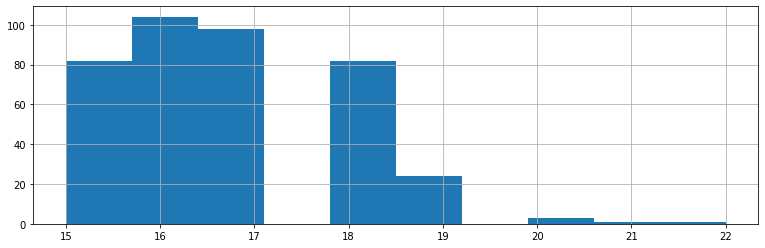

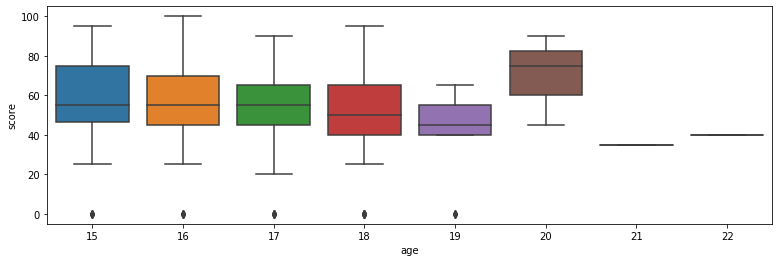

In [105]:
info_columns(stud_math.age)
stud_math.age.describe()
limits(stud_math.age)
show_histo(stud_math.age)
get_boxplot(stud_math.age)

Колонка "Age", определяет возраст ученика. Данная колонка не имеет пустых значений. Распределение не равномерное, имеются выбросы, хотя вполне могут обучаться студенты и более старшего возраста, данных очень мало, считаю удаление будет не совсем корректным. С увеличением возраста количество учеников и максимально набранные ими баллы уменьшаются.

In [106]:
info_columns(stud_math.urbanite)

Уникальные значения: 
 1.0    295
0.0     83
Name: urbanite, dtype: int64 
 Пустые значения (кол-во): 17 
 Пустые значения (%): 4.3


Колонка "Urbanite", определяет где живет ученик (в городе, либо за городом). Данная колонка имеет 17 пустых значений (4.3%), очевидно она связана со значениями "traveltime" и "reason", если в причинах выбора школы выбран пункт "близость к дому" и время в пути занимает менее 30 минут, можем предположить что ученик - городской житель. Создадим функцию, которая заполнит пустые значения единицей, если причина - близость к дому, либо время в пути менее 30 минут, остальные не заполненные значения (кол-во 2) заполним случайным значением в колонке (о или 1), полагаю мы можем себе это позволить, тк 2 пропущенных значения составляют менее 0.5% и не скажутся на влиянии данного признака на баллы ученика:

In [107]:
def for_urban(urbanite,reason,traveltime):
    if urbanite!=0 and urbanite!=1:
        if reason==1 or traveltime==1 or traveltime==2:
            return 1
        else:
            return np.random.choice([0,1])
    else:
        return urbanite
    
stud_math.urbanite=stud_math.apply(lambda x:for_urban(x.urbanite,x.reason,x.traveltime), axis=1)

25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
Имеются выбросы


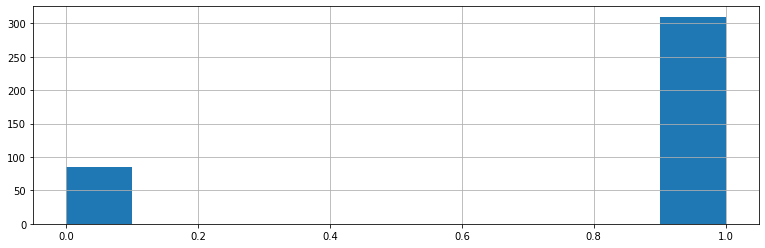

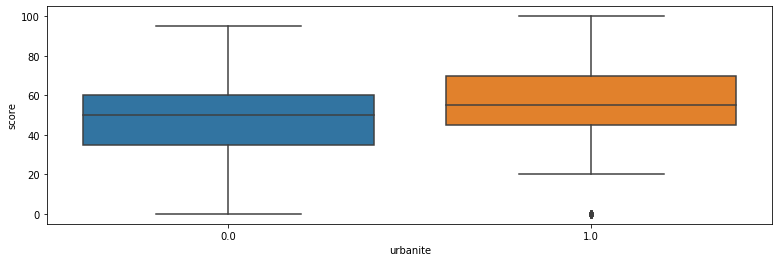

In [108]:
limits(stud_math.urbanite)
show_histo(stud_math.urbanite)
get_boxplot(stud_math.urbanite)

В целом учеников живущих в городе намного больше живущих загородом, ученики живущие в черте города получают в среднем более высокие баллы на экзаменах

In [109]:
info_columns(stud_math.famsize_more3)

Уникальные значения: 
 1.0    261
0.0    107
Name: famsize_more3, dtype: int64 
 Пустые значения (кол-во): 27 
 Пустые значения (%): 6.8


Колонка "famsize_more3", определяет количество людей в семье ученика (более 3, либо равно/менее 3). Данная колонка имеет 27 пустых значений (6.8%), очевидной связи размера семьи с другими признаками не возможно определить. При замене пустых значений на медианное, приведет к несущественному усилению признака "более 3" на 3,8%:

In [110]:
stud_math.famsize_more3=stud_math.famsize_more3.apply(lambda x: 1 if pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].


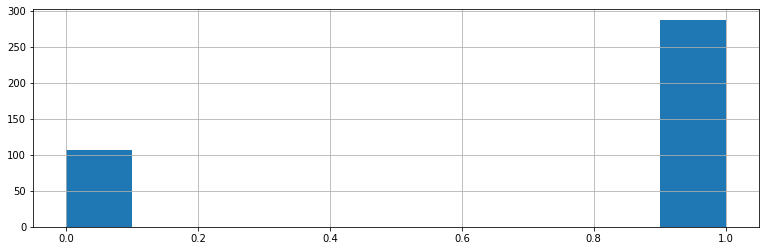

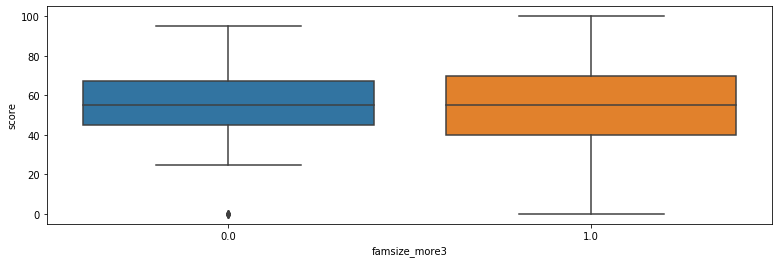

In [111]:
limits(stud_math.famsize_more3)
show_histo(stud_math.famsize_more3)
get_boxplot(stud_math.famsize_more3)

Из графика видно что распределение баллов на экзаменах особо не зависит от размера семьи

In [112]:
info_columns(stud_math.Pstatus_together)
stud_math.Pstatus_together.describe()

Уникальные значения: 
 1.0    314
0.0     36
Name: Pstatus_together, dtype: int64 
 Пустые значения (кол-во): 45 
 Пустые значения (%): 11.4


count    350.000000
mean       0.897143
std        0.304207
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Pstatus_together, dtype: float64

Колонка "Pstatus_together", определяет семейный статус родителей ученика (вместе либо раздельно). Данная колонка имеет 45 пустых значений (11.4%), У 82% семей, в которых более трех членов в семье - родители живут вместе, в таком случае смею предположить в пропущенных значениях, где размер семьи "более 3 человек" - родители живут вместе. Таких значений 28, остальные значения можно заполнить так же единицей (медианным значением), что приведет к несущественному усилению признака "живут вместе" на 4,3%:

In [113]:
stud_math.Pstatus_together=stud_math.Pstatus_together.apply(lambda x: 1 if pd.isnull(x) else x)

25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
Имеются выбросы


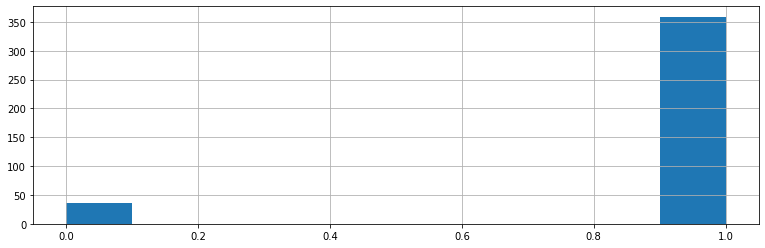

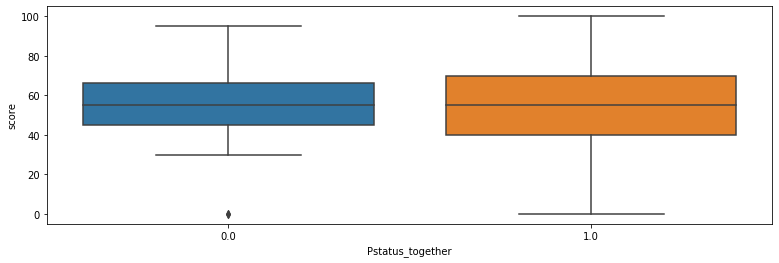

In [114]:
limits(stud_math.Pstatus_together)
show_histo(stud_math.Pstatus_together)
get_boxplot(stud_math.Pstatus_together)

Из графика можно сделать вывод, что количество баллов на экзамене не зависит от статуса проживания родителей ученика.

In [115]:
info_columns(stud_math.Medu)
stud_math.Medu.describe()

Уникальные значения: 
 4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64 
 Пустые значения (кол-во): 3 
 Пустые значения (%): 0.8


count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

Колонка "Medu", определяет уровень образования матери ученика (от 0 - без образования до 4 - высшего). Данная колонка имеет всего 3 пустых значений (0,8%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на самое часто повторяющееся, приведет к несущественному усилению признака "высшее образование" на 0,8%:

In [116]:
stud_math.Medu=stud_math.Medu.apply(lambda x:4 if pd.isnull(x) else x)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


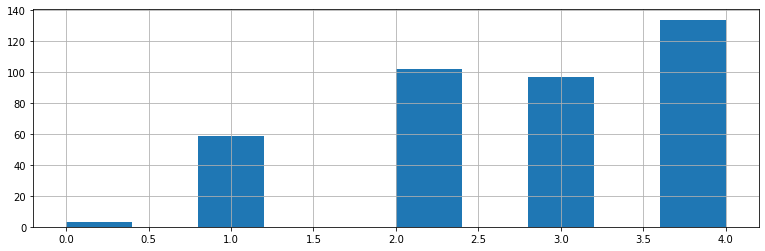

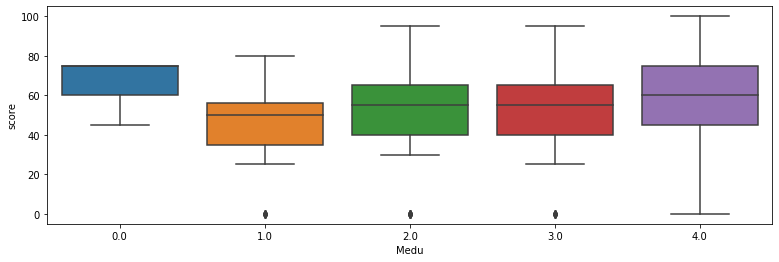

In [117]:
limits(stud_math.Medu)
show_histo(stud_math.Medu)
get_boxplot(stud_math.Medu)

Судя по графикам, уровень образования матери довольно сильно влияет на средний балл ученика, даже необходимо обратить внимание на высокие баллы учеников, матери которых не имеют образования вообще, видимо это служит сильным стимулом (болевой точкой матери) для хороших оценок ребенка. Также чем выше образование у матери тем больше вероятность что ребенка отдадут обучение математики

In [118]:
info_columns(stud_math.Fedu)
stud_math.Fedu.describe()

Уникальные значения: 
 2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64 
 Пустые значения (кол-во): 24 
 Пустые значения (%): 6.1


count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

Колонка "Fedu", определяет уровень образования отца ученика (от 0 - без образования до 4 - высшего). Данная колонка имеет 24 пустых значений (6%) видимо анкету заполняли матери, либо отцы слишком ленивы, чтобы заполнить информацию о себе. В глаза бросается значение 40, думаю можем считать это опечаткой и заменим на 4.0. Также хочется надеется что родители работающие в сфере здравохранения и образования (колонка "Fjob") имеют высшее образование - заменим пустые значения у них на 4.0. т.к. признаки от 1 до 4 распределены относительно равномерно, остальные 19 значений заменим случайным значением от 1 до 4:

In [119]:
def for_Fedu(Fedu,Fjob):
    if Fedu!=0 and Fedu!=1 and Fedu!=2 and Fedu!=3 and Fedu!=4:
        if Fjob==1 or Fjob==2 or Fedu==40:
            return 4
        else:
            return np.random.choice([1,4])
    else:
        return Fedu
    
stud_math.Fedu=stud_math.apply(lambda x:for_Fedu(x.Fedu,x.Fjob), axis=1)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


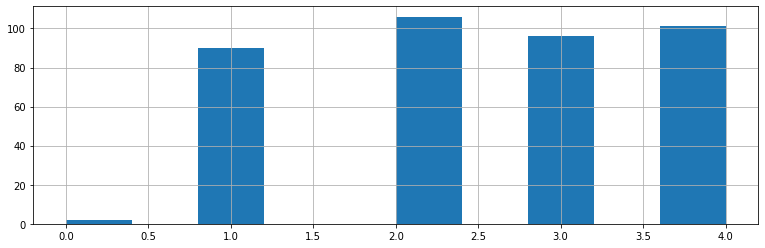

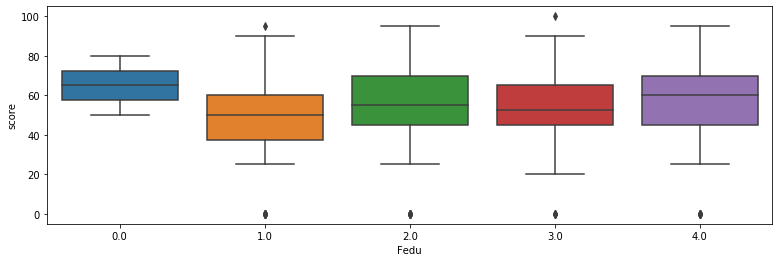

In [120]:
limits(stud_math.Fedu)
show_histo(stud_math.Fedu)
get_boxplot(stud_math.Fedu)

Образование отца не особо влияет на получение хороших оценок на экзамене по математике, за исключением тех отцов у которых нет образования вовсе, здесь имеется схожесть с моделью поведения матерей, видимо "хорошие оценки" основная цель у родителей без образования независимо от роли.

In [121]:
info_columns(stud_math.Mjob)
stud_math.Mjob.describe()

Уникальные значения: 
 5.0    133
3.0     98
4.0     58
1.0     55
2.0     32
Name: Mjob, dtype: int64 
 Пустые значения (кол-во): 19 
 Пустые значения (%): 4.8


count    376.000000
mean       3.484043
std        1.417890
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Mjob, dtype: float64

Колонка "Mjob" - место работы матери ученика (1 - сфера образования, 2 - сфера зравохранения, 3 - гос.служба, 4 - без работы, 5 - прочее). Данная колонка имеет 19 пустых значений (4,8%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на случайное значение не приведет к существенному отклонению значений, тк доля пропусков составлееет менее 5%:

In [122]:
stud_math.Mjob=stud_math.Mjob.apply(lambda x: np.random.choice([1,5]) if pd.isnull(x) else x)

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


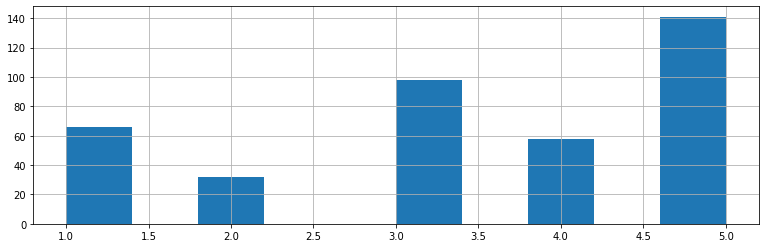

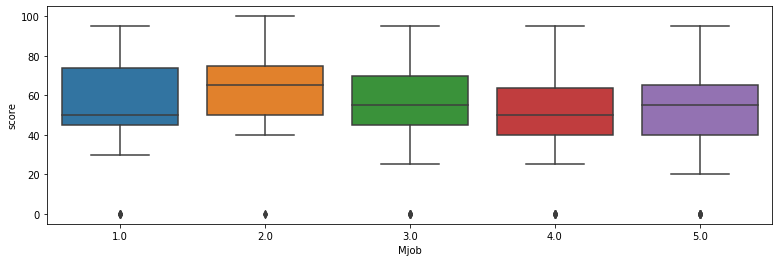

In [123]:
limits(stud_math.Mjob)
show_histo(stud_math.Mjob)
get_boxplot(stud_math.Mjob)

Сфера деятельности матери на получение высоких баллов по математике влияет, так же как у уровень образования матери, в тех сферах где у матери должен быть уровень высокий, дети показывают более высокие баллы (здравохранение и образование)

In [124]:
info_columns(stud_math.Fjob)
stud_math.Fjob.describe()

Уникальные значения: 
 5.0    197
3.0    102
1.0     29
4.0     16
2.0     15
Name: Fjob, dtype: int64 
 Пустые значения (кол-во): 36 
 Пустые значения (%): 9.1


count    359.000000
mean       3.938719
std        1.314564
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Fjob, dtype: float64

Колонка "Fjob" - место работы отца ученика (1 - сфера образования, 2 - сфера зравохранения, 3 - гос.служба, 4 - без работы, 5 - прочее). Данная колонка имеет 36 пустых значений (9%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. В основном, согласно данных, родитель с высшим образованием работает не сидит дома, а также родитель без высшего образования выбирает работу не в сфере образования и здравохраниения, напишем такую функцию, которая учтет это и присвоим рэндомно возможные варианты:

In [125]:
def for_Fjob(Fedu,Fjob):
    if Fjob!=1 and Fjob!=5 and Fjob!=2 and Fjob!=3 and Fjob!=4:
        if Fedu==4:
            return np.random.choice([1,3])
        else:
            return np.random.choice([3,5])
    else:
        return Fjob
    
stud_math.Fjob=stud_math.apply(lambda x:for_Fjob(x.Fedu,x.Fjob), axis=1)

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


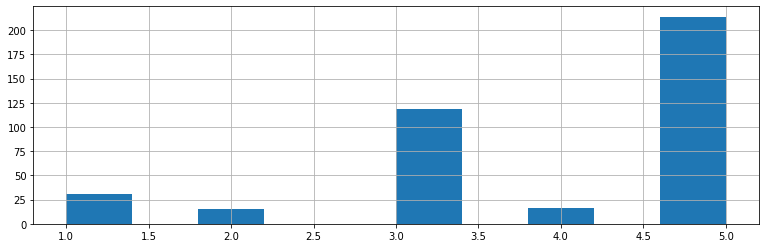

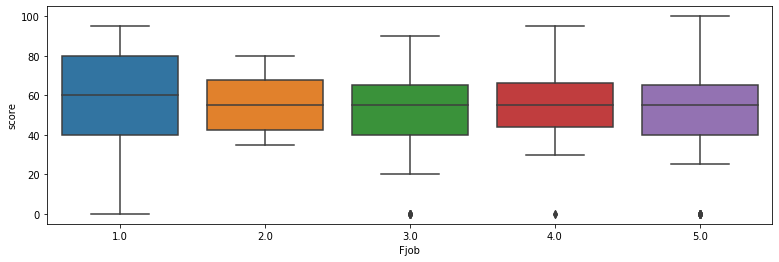

In [126]:
limits(stud_math.Fjob)
show_histo(stud_math.Fjob)
get_boxplot(stud_math.Fjob)

Намного выше средний балл у учеников отцы которых работают в сфере образования, видимо собственный пример является важной состоявляющей, либо отцы хорошо могут донести материал ребенку и поработать дополнительно

In [127]:
info_columns(stud_math.reason)
stud_math.reason.describe()

Уникальные значения: 
 3.0    137
1.0    104
2.0    103
4.0     34
Name: reason, dtype: int64 
 Пустые значения (кол-во): 17 
 Пустые значения (%): 4.3


count    378.000000
mean       2.267196
std        0.963544
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: reason, dtype: float64

Колонка "reason" - причина выбора той или иной школы для обучения (1 - близость к дому, 2 - репутация школы, 3 - образовательная программа, 4 - другое). Данная колонка имеет всего 17 пустых значений (4.3%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Предположим что если ученик добирается до школы за менее чем 30 минут, то причиной выбора данной школы в основном служит близость школы к дому, остальные значения заменим рэндомно на самые популярные:

In [128]:
def for_reason(reason,traveltime):
    if reason!=1 and reason!=2 and reason!=3 and reason!=4:
        if traveltime==1 or traveltime==2:
            return 1
        else:
            return np.random.choice([2,3])
    else:
        return reason
    
stud_math.reason=stud_math.apply(lambda x:for_reason(x.reason,x.traveltime), axis=1)

25-й перцентиль: 1.0, 75-й перцентиль: 3.0, IQR: 2.0,  Границы выбросов: [-2.0, 6.0].


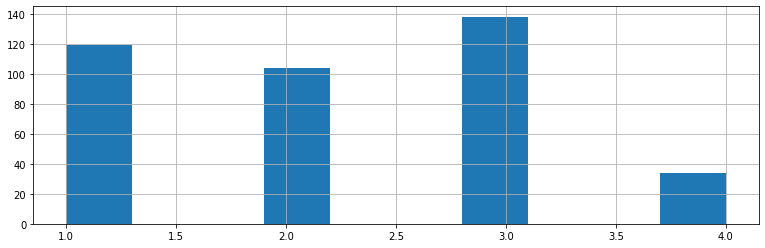

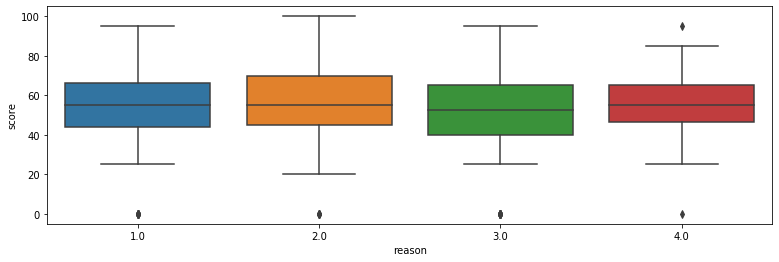

In [129]:
limits(stud_math.reason)
show_histo(stud_math.reason)
get_boxplot(stud_math.reason)

Причина выбора школы не влияет на оценки по математике у учеников

In [130]:
info_columns(stud_math.guardian)
stud_math.guardian.describe()

Уникальные значения: 
 1.0    250
2.0     86
3.0     28
Name: guardian, dtype: int64 
 Пустые значения (кол-во): 31 
 Пустые значения (%): 7.8


count    364.000000
mean       1.390110
std        0.626777
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: guardian, dtype: float64

Колонка "guardian" - кто является основным опекуном ученика - ответсвенное лицо по всей видимости (1 - мать, 2 - отец, 3 - другое). Данная колонка имеет 31 пустое значение (7,8%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Согласно данных, на значение опекуна не влияет пол ребенка, значения распределены относительно равномерно. Возможно после 18 лет ученику не нужен опекун, тк от 18 лет значение "другое" резко возрастает, в таком случае всем ученикам старше 18 лет можно присвоить значение 3 "другое", а до 18 лет рэмдомно распределить между значениями 1 и 2:

In [131]:
def for_guardian(guardian,age):
    if guardian!=1 and guardian!=2 and guardian!=3:
        if age<18:
            return np.random.choice([1,2])
        else:
            return 3
    else:
        return guardian
    
stud_math.guardian=stud_math.apply(lambda x:for_guardian(x.guardian,x.age), axis=1)

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


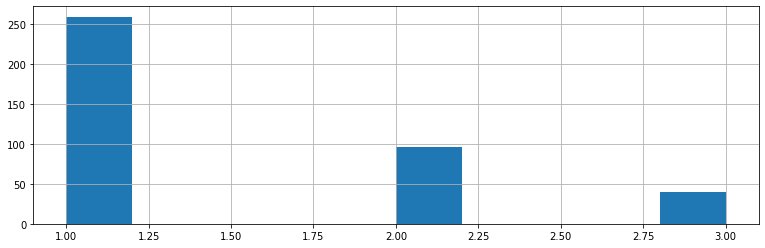

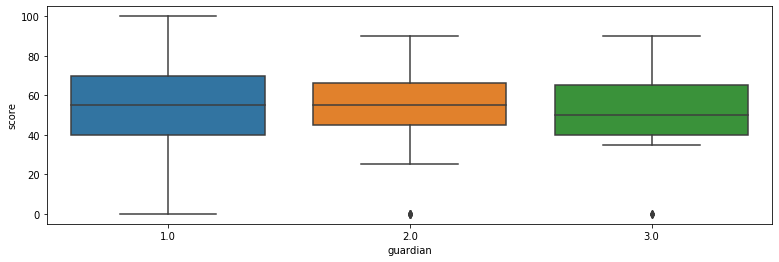

In [132]:
limits(stud_math.guardian)
show_histo(stud_math.guardian)
get_boxplot(stud_math.guardian)

Средний балл по математике у детей, опекуном которых является кто-то иной от матери и отца, немного ниже

In [133]:
info_columns(stud_math.traveltime)
stud_math.traveltime.describe()

Уникальные значения: 
 1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64 
 Пустые значения (кол-во): 28 
 Пустые значения (%): 7.1


count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

Колонка "traveltime" - время в пути ученика от дома до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.). Данная колонка имеет 28 пустых значений (7.1%). Варианты ответов заполнены согласно предложенного списка. Если причиной выбора школы служит близость школы к дому, а также смею предположить что если ученик живет в городе, то также затрачивает на дорогу не более часа - значени 1-3, остальные значения заменим на 4 (ученикам которые живут за чертой города):

In [134]:
def for_traveltime(urbanite,reason,traveltime):
    if traveltime!=1 and traveltime!=2 and traveltime!=3 and traveltime!=4:
        if reason==1 or urbanite==1:
            return np.random.choice([1,3])
        else:
            return 4
    else:
        return traveltime
    
stud_math.traveltime=stud_math.apply(lambda x:for_traveltime(x.urbanite,x.reason,x.traveltime), axis=1)

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Имеются выбросы


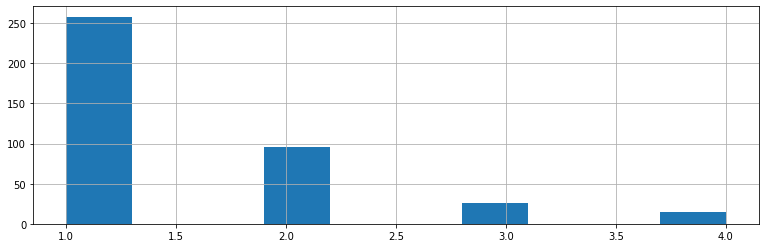

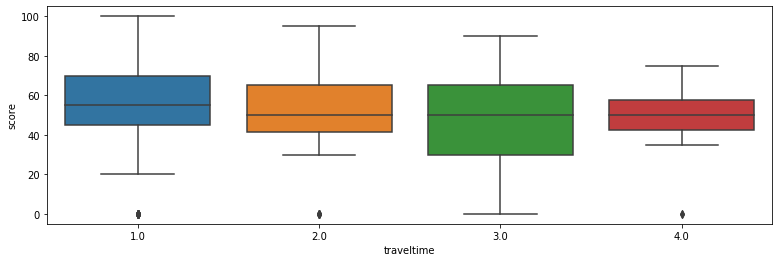

In [135]:
limits(stud_math.traveltime)
show_histo(stud_math.traveltime)
get_boxplot(stud_math.traveltime)

Зависимости времени затрачиваемого на путь до школы и оценок по математике не наблюдается

In [136]:
info_columns(stud_math.studytime)
stud_math.studytime.describe()

Уникальные значения: 
 2.0    194
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64 
 Пустые значения (кол-во): 8 
 Пустые значения (%): 2.0


count    387.000000
mean       2.036176
std        0.841744
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

Колонка "studytime" - время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов). Данная колонка имеет всего 7 пустых значений (менее 2%). Варианты ответов заполнены согласно предложенного списка. Заменим пустые значения на самые популярные 1/2: 

In [137]:
stud_math.studytime=stud_math.studytime.apply(lambda x: np.random.choice([1,2]) if pd.isnull(x) else x)

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].
Имеются выбросы


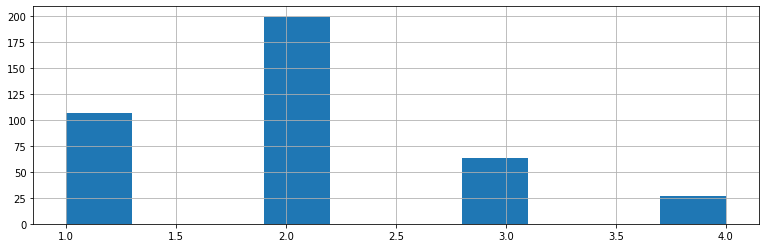

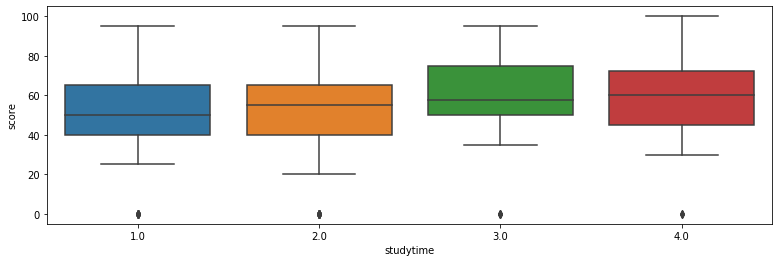

In [138]:
limits(stud_math.studytime)
show_histo(stud_math.studytime)
get_boxplot(stud_math.studytime)

Чем больше ученик затрачивает время на учебу тем выше его баллы, но эта закономерность сохраняется до 10 часов, затем эффективносьт обучения падает, оценки не становятся выше

In [139]:
info_columns(stud_math.failures)
stud_math.failures.describe()

Уникальные значения: 
 0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64 
 Пустые значения (кол-во): 22 
 Пустые значения (%): 5.6


count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Колонка "failures" - количество внеучебных неудач (n, если 1<=n<3, иначе 0). Данная колонка имеет 22 пустых значений (5.6%). Варианты ответов заполнены согласно предложенного списка. Согласно данных, в основном, при наличии поддержки со стороны семьи и школы, у ученика количество неудач стремится к 0, остальные значения заменим на рэндомное от 0 до 3:

In [140]:
def for_failures(failures,famsup,schoolsup):
    if failures!=1 and failures!=2 and failures!=3 and failures!=0:
        if famsup==1 or schoolsup==1:
            return 0
        else:
            return np.random.choice([0,3])
    else:
        return failures
    
stud_math.failures=stud_math.apply(lambda x:for_failures(x.failures,x.famsup,x.schoolsup), axis=1)

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Имеются выбросы


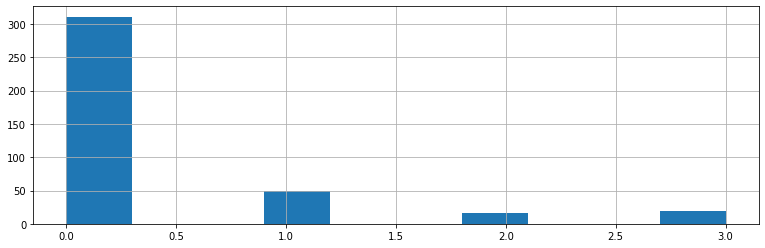

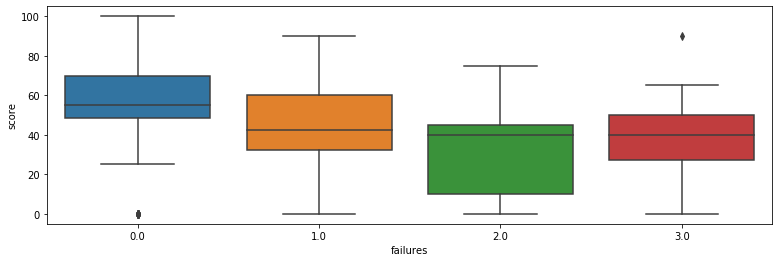

In [141]:
limits(stud_math.failures)
show_histo(stud_math.failures)
get_boxplot(stud_math.failures)

наблюдается зависимость от количества внеучебных неудач на оценки по математике, чем больше неудач тем ниже средняя оценка у наблюдаемой группы. Имеются выбросы в 0 и 3 категории, но данные значения имеют право на существование и удалять их сичтаю не целесообразным.

In [142]:
info_columns(stud_math.schoolsup)
stud_math.schoolsup.describe()

Уникальные значения: 
 0.0    335
1.0     51
Name: schoolsup, dtype: int64 
 Пустые значения (кол-во): 9 
 Пустые значения (%): 2.3


count    386.000000
mean       0.132124
std        0.339065
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: schoolsup, dtype: float64

Колонка "schoolsup", определяет имеется ли дополнительная образовательная поддержка ученику (1 - да, 0 - нет). Данная колонка имеет всего 9 пустых значений (2,3%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на самое популярное или медианное, в данном случае значение одно и то же, приведет к несущественному усилению признака "поддержки нет" менее чем на 3%:

In [143]:
stud_math.schoolsup=stud_math.schoolsup.apply(lambda x: 0 if pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Имеются выбросы


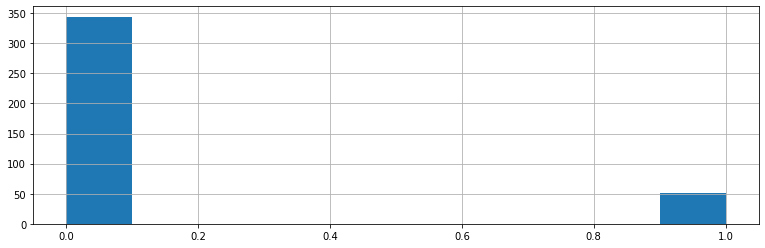

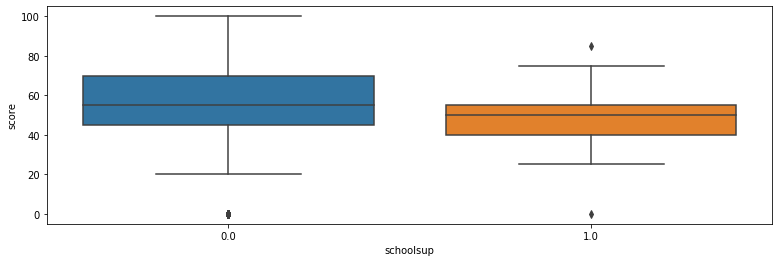

In [144]:
limits(stud_math.schoolsup)
show_histo(stud_math.schoolsup)
get_boxplot(stud_math.schoolsup)

Поддержки школы по всей видимости ученикам не нужно, чем больше вмешиваются тем ниже результат

In [145]:
info_columns(stud_math.famsup)
stud_math.famsup.describe()

Уникальные значения: 
 1.0    219
0.0    137
Name: famsup, dtype: int64 
 Пустые значения (кол-во): 39 
 Пустые значения (%): 9.9


count    356.000000
mean       0.615169
std        0.487240
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: famsup, dtype: float64

Колонка "famsup", определяет имеется ли дополнительная семейная образовательная поддержка ученику (1 - да, 0 - нет). Данная колонка имеет 39 пустых значений (9,9%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на рэндомное значение 0/1 не приведет к существенному усилению того или иного признака:

In [146]:
stud_math.famsup=stud_math.famsup.apply(lambda x: np.random.choice([0,1]) if pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].


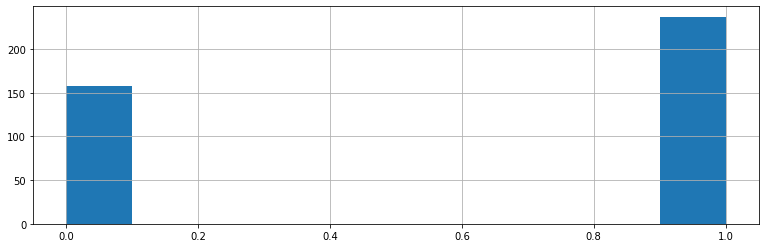

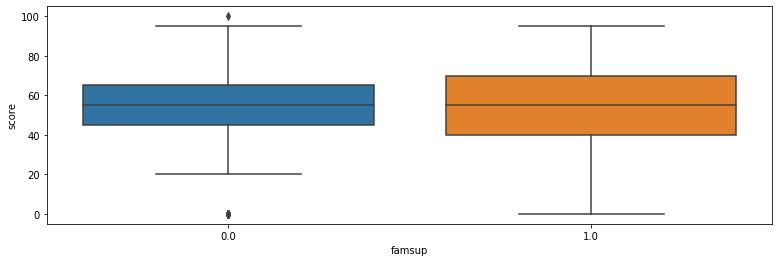

In [147]:
limits(stud_math.famsup)
show_histo(stud_math.famsup)
get_boxplot(stud_math.famsup)

Поддержка родителей никак не влияет на рельтаты экзаменов. Выбросов нет.

In [148]:
info_columns(stud_math.paid)
stud_math.paid.describe()

Уникальные значения: 
 0.0    200
1.0    155
Name: paid, dtype: int64 
 Пустые значения (кол-во): 40 
 Пустые значения (%): 10.1


count    355.000000
mean       0.436620
std        0.496667
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: paid, dtype: float64

Колонка "paid", определяет имеются ли дополнительные платные занятия по математике у ученика. Данная колонка имеет 40 пустых значений (10%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на рэндомное значение 0/1 не приведет к существенному усилению того или иного признака:

In [149]:
stud_math.paid=stud_math.paid.apply(lambda x: np.random.choice([0,1]) if pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].


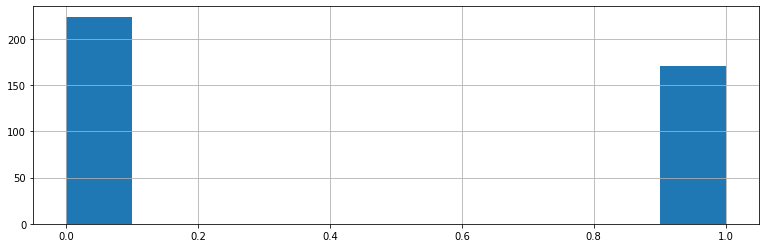

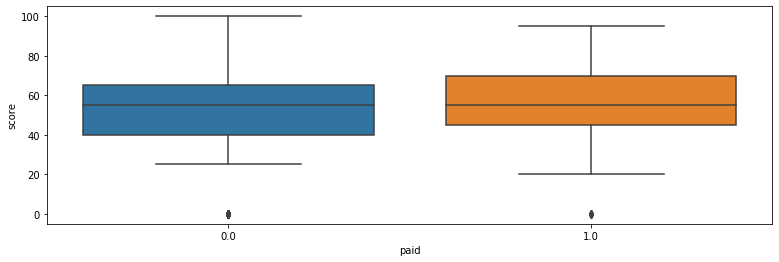

In [150]:
limits(stud_math.paid)
show_histo(stud_math.paid)
get_boxplot(stud_math.paid)

Дополнительные платные занятия по математике у ученика конечно же позитивно влияют на оценку по экзамену по математике, имеются выбросы, которые имеют место быть

In [151]:
info_columns(stud_math.activities)
stud_math.activities.describe()

Уникальные значения: 
 1.0    195
0.0    186
Name: activities, dtype: int64 
 Пустые значения (кол-во): 14 
 Пустые значения (%): 3.5


count    381.000000
mean       0.511811
std        0.500518
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: activities, dtype: float64

Колонка "activities", определяет имеются ли дополнительные внеучебные занятия у ученика (1 - да, 0 - нет). Данная колонка имеет 14 пустых значений (3%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на рэндомное значение 0/1 не приведет к существенному усилению того или иного признака, тк значения распределены относительно равномерно:

In [152]:
stud_math.activities=stud_math.activities.apply(lambda x: np.random.choice([0,1]) if pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].


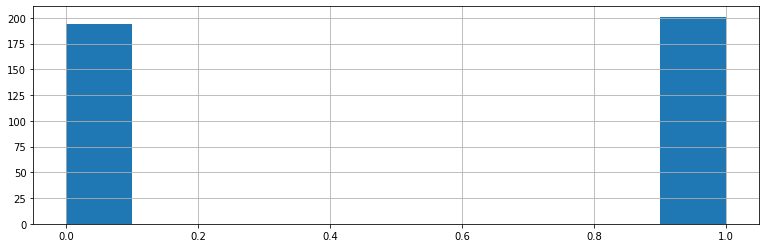

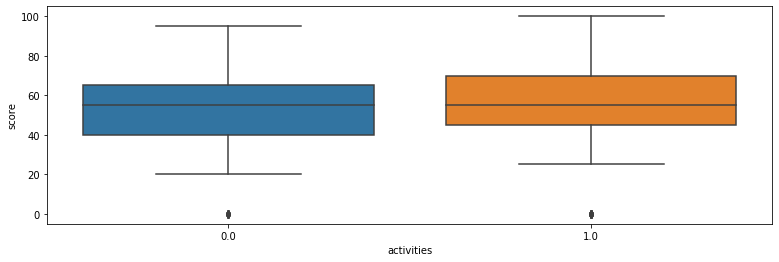

In [153]:
limits(stud_math.activities)
show_histo(stud_math.activities)
get_boxplot(stud_math.activities)

В целом ученики, которые имеют дополнительные внеучебные занятия, пишут экзамены лучше, но также имеются выбросы

In [154]:
info_columns(stud_math.nursery)
stud_math.nursery.describe()

Уникальные значения: 
 1.0    300
0.0     79
Name: nursery, dtype: int64 
 Пустые значения (кол-во): 16 
 Пустые значения (%): 4.1


count    379.000000
mean       0.791557
std        0.406732
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nursery, dtype: float64

Колонка "nursery", посещал детский сад ученик (1 - да, 0 - нет). Данная колонка имеет16 пустых значений (4%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на медианное не приведет к существенному усилению того или иного признака:

In [155]:
stud_math.nursery=stud_math.nursery.apply(lambda x: 1 if pd.isnull(x) else x)

In [156]:
info_columns(stud_math.granular_studytime)
stud_math.granular_studytime.describe()

Уникальные значения: 
 -6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: granular_studytime, dtype: int64 
 Пустые значения (кол-во): 7 
 Пустые значения (%): 1.8


count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: granular_studytime, dtype: float64

Значения в колонке "granular_studytime" коррелирует со значениями в колонке "studytime" с коэф. -1. Предлагаю его удалить и отражать влияние только "studytime" на баллы ученика:

In [157]:
stud_math = stud_math.drop('granular_studytime', axis=1)

In [158]:
info_columns(stud_math.higher)
stud_math.higher.describe()

Уникальные значения: 
 1.0    356
0.0     19
Name: higher, dtype: int64 
 Пустые значения (кол-во): 20 
 Пустые значения (%): 5.1


count    375.000000
mean       0.949333
std        0.219609
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: higher, dtype: float64

Колонка "higher", хочет получить высшее образование ученик (1 - да, 0 - нет). Данная колонка имеет 20 пустых значений (5%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на рэндомное не приведет к существенному усилению того или иного признака, усиление не более 5%:

In [159]:
stud_math.higher=stud_math.higher.apply(lambda x: np.random.choice([0,1]) if pd.isnull(x) else x)

25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
Имеются выбросы


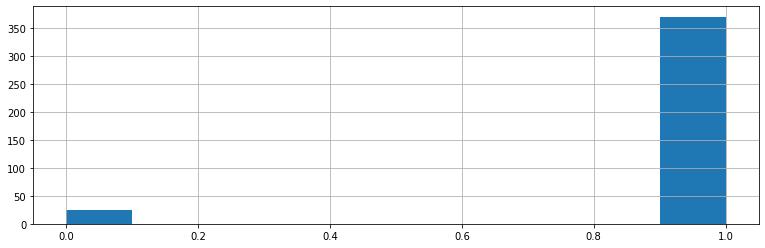

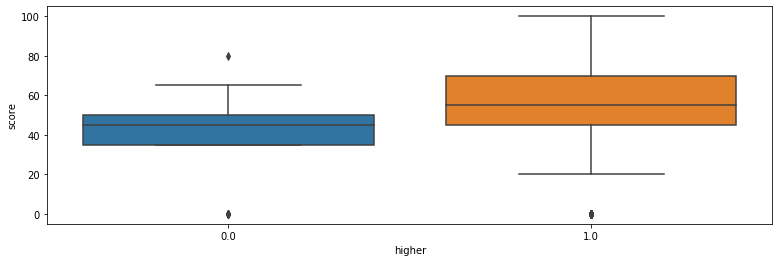

In [160]:
limits(stud_math.higher)
show_histo(stud_math.higher)
get_boxplot(stud_math.higher)

Очевидно, если ученик планирует получить высшее образование - будет более старательным и постарается написать экзамен хорошо. Данное утверждение демонстрируют и подтверждают графики выше. Имеются незначительные выбросы

In [161]:
info_columns(stud_math.internet)
stud_math.internet.describe()

Уникальные значения: 
 1.0    305
0.0     56
Name: internet, dtype: int64 
 Пустые значения (кол-во): 34 
 Пустые значения (%): 8.6


count    361.000000
mean       0.844875
std        0.362526
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: internet, dtype: float64

Колонка "internet", наличие интернета дома у ученика (1 - да, 0 - нет). Данная колонка имеет 34 пустых значений (8.6%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Замена пустых значений на рэндомное не приведет к существенному усилению того или иного признака, у более чем 80% учеников имеется интернет:

In [162]:
stud_math.internet=stud_math.internet.apply(lambda x: np.random.choice([0,1]) if pd.isnull(x) else x)

25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].
Имеются выбросы


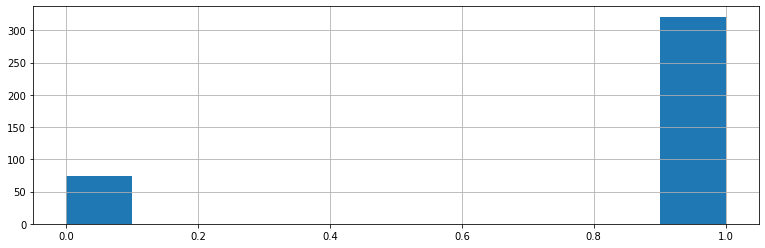

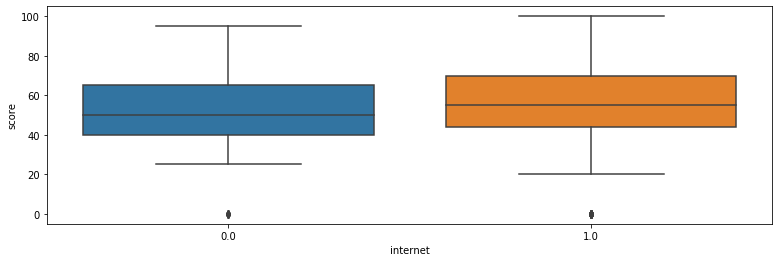

In [163]:
limits(stud_math.internet)
show_histo(stud_math.internet)
get_boxplot(stud_math.internet)

Наличие интернета позитивно сказывается на оценках учеников

In [164]:
info_columns(stud_math.romantic)
stud_math.romantic.describe()

Уникальные значения: 
 0.0    240
1.0    124
Name: romantic, dtype: int64 
 Пустые значения (кол-во): 31 
 Пустые значения (%): 7.8


count    364.000000
mean       0.340659
std        0.474583
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: romantic, dtype: float64

Колонка "romantic", находится ли в романтических отношениях ученик (1 - да, 0 - нет). Данная колонка имеет 31 пустое значение (7.8%). Изначально признак номинативный, варианты ответов заполнены согласно предложенного списка. Согласно данных, чем больше свободного времени у ученика, тем выше вероятность нахождения ученика в романтических отношениях, в таком случае если наличие свободного времени у ученика в диапазоне 1-2, то скорее вего ученик не состоит в романтических отношениях:

In [165]:
def for_romantic(romantic,freetime):
    if romantic!=1 and romantic!=0:
        if freetime==1 or freetime==2:
            return 0
        else:
            return np.random.choice([0,1])
    else:
        return romantic
    
stud_math.romantic=stud_math.apply(lambda x:for_romantic(x.romantic,x.freetime), axis=1)

25-й перцентиль: 0.0, 75-й перцентиль: 1.0, IQR: 1.0,  Границы выбросов: [-1.5, 2.5].


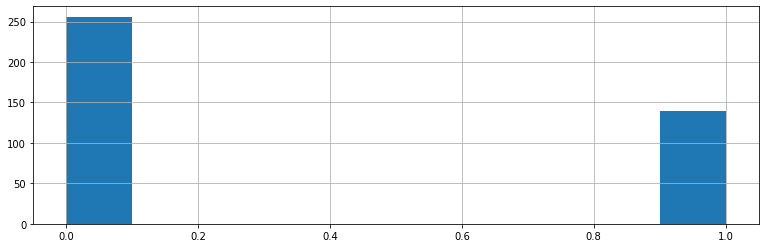

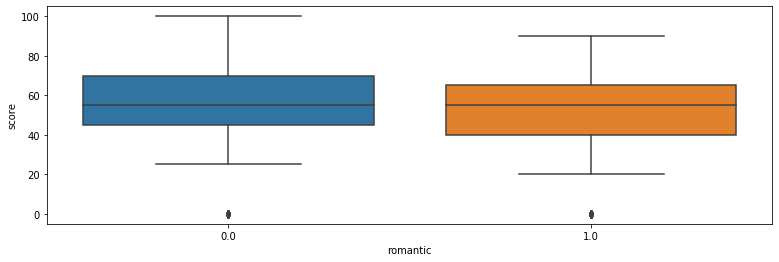

In [166]:
limits(stud_math.romantic)
show_histo(stud_math.romantic)
get_boxplot(stud_math.romantic)

А вот наличие романтических отношений негативно сказывается на оценках учеников, что является в целом очевидным фактом

In [168]:
info_columns(stud_math.famrel)
stud_math.famrel.describe()

Уникальные значения: 
  4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64 
 Пустые значения (кол-во): 27 
 Пустые значения (%): 6.8


count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

Колонка "famrel", семейные отношения (от 1 - очень плохо до 5 - очень хорошо). Данная колонка имеет 27 пустых значений (6.8%). В глаза бросается значение -1, думаю можем считать это опечаткой и заменим на 1. Остальные пустые значения заменим случайным значением самых популярных от 2 до 5:

In [169]:
stud_math.famrel=stud_math.famrel.apply(lambda x: np.random.choice([2,5]) if pd.isnull(x) else x)
stud_math.famrel=stud_math.famrel.apply(lambda x: 1 if x==-1 else x)

25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].
Имеются выбросы


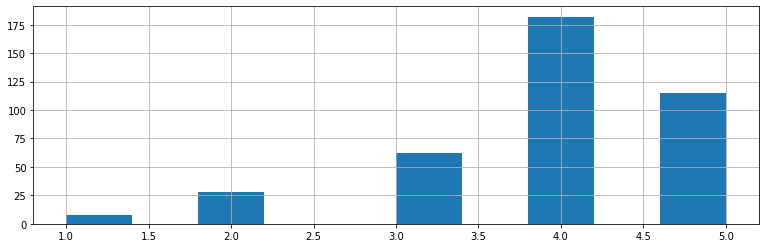

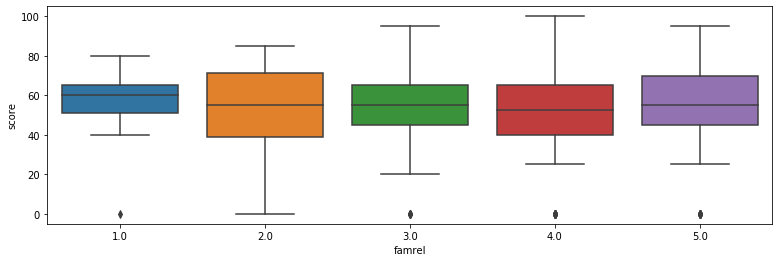

In [170]:
limits(stud_math.famrel)
show_histo(stud_math.famrel)
get_boxplot(stud_math.famrel)

не наблюдается зависимости семейных отношений на оценки учеников

In [171]:
info_columns(stud_math.freetime)
stud_math.freetime.describe()

Уникальные значения: 
 3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
Name: freetime, dtype: int64 
 Пустые значения (кол-во): 11 
 Пустые значения (%): 2.8


count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

Колонка "freetime", свободное время после школы (от 1 - очень мало до 5 - очень много). Данная колонка имеет 11 пустых значений (2.8%). Варианты ответов заполнены согласно предложенного списка. Остальные пустые значения заменим значениями в поле "goout", тк проведение времени с друзьями коррелирует со свободным временем в основном:

In [172]:
def for_freetime(freetime,goout):
    if freetime!=1 and freetime!=2 and freetime!=3 and freetime!=4 and freetime!=5:
        return goout
    else:
        return freetime
    
stud_math.freetime=stud_math.apply(lambda x:for_freetime(x.freetime,x.goout), axis=1)

25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].
Имеются выбросы


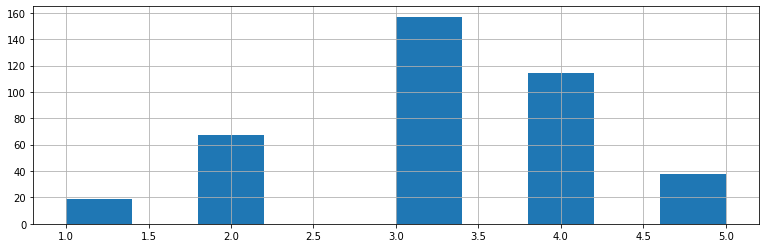

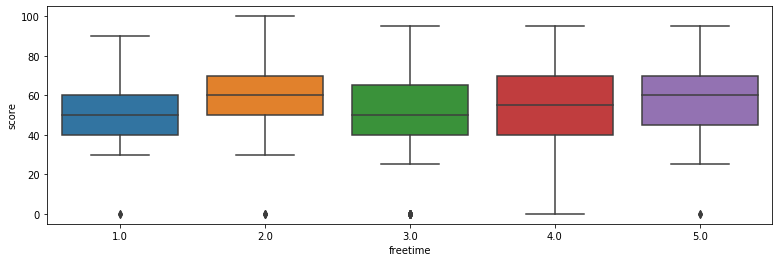

In [173]:
limits(stud_math.freetime)
show_histo(stud_math.freetime)
get_boxplot(stud_math.freetime)

не наблюдается зависимости между наличием свободного времени и оценками на экзамене учеников

In [174]:
info_columns(stud_math.goout)
stud_math.goout.describe()

Уникальные значения: 
 3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Name: goout, dtype: int64 
 Пустые значения (кол-во): 8 
 Пустые значения (%): 2.0


count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

Колонка "goout", проведение времени с друзьями  (от 1 - очень мало до 5 - очень много). Данная колонка имеет 8 пустых значений (всего 2%). Варианты ответов заполнены согласно предложенного списка. Остальные пустые значения заменим значениями в поле "freetime", тк проведение времени с друзьями коррелирует со свободным временем в основном:

In [175]:
def for_goout(freetime,goout):
    if goout!=1 and goout!=2 and goout!=3 and goout!=4 and goout!=5:
        return freetime
    else:
        return goout
    
stud_math.goout=stud_math.apply(lambda x:for_goout(x.freetime,x.goout), axis=1)

25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


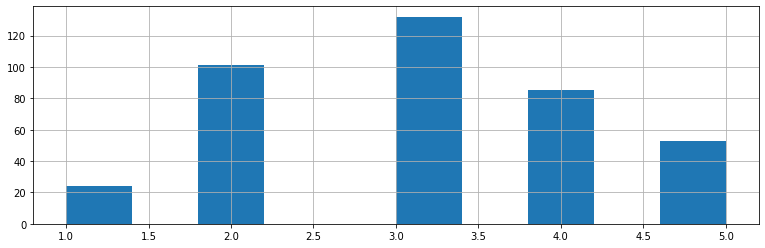

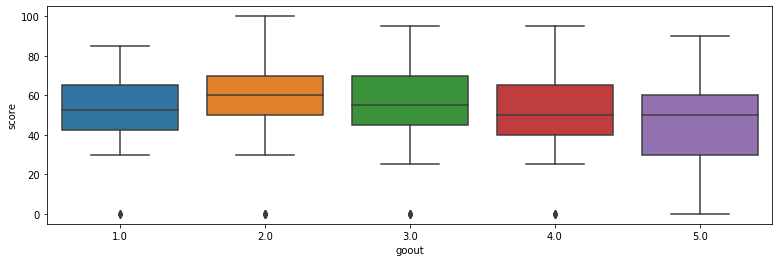

In [176]:
limits(stud_math.goout)
show_histo(stud_math.goout)
get_boxplot(stud_math.goout)

 проведение времени с друзьями коррелирует со свободным временем, поэтому и тут не особо наблюдается зависимости с оценками учеников

In [177]:
info_columns(stud_math.health)
stud_math.health.describe()

Уникальные значения: 
 5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
Name: health, dtype: int64 
 Пустые значения (кол-во): 15 
 Пустые значения (%): 3.8


count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Колонка "health", текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо). Данная колонка имеет 15 пустых значений (всего 3.8%). Варианты ответов заполнены согласно предложенного списка. Остальные пустые значения заменим рэндомным значением:

In [178]:
stud_math.health=stud_math.health.apply(lambda x: np.random.choice([1,5]) if pd.isnull(x) else x)

25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


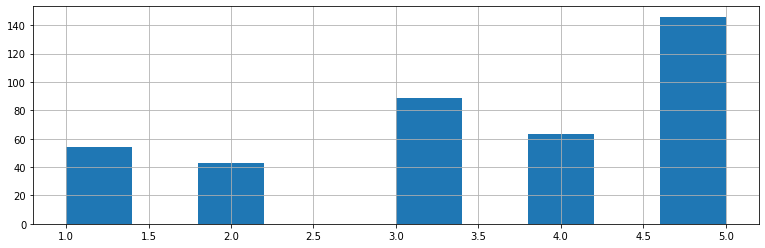

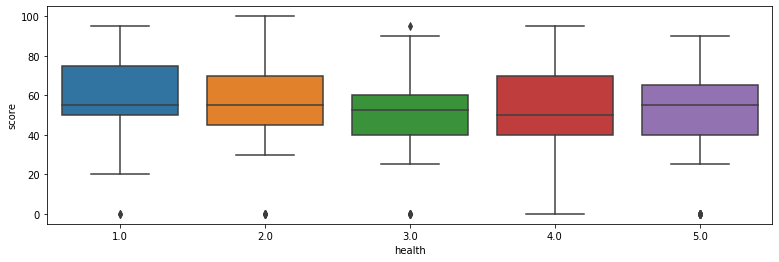

In [179]:
limits(stud_math.health)
show_histo(stud_math.health)
get_boxplot(stud_math.health)

здоровье ученика и оценки на экзамене по математике не зависят друг от друга

In [180]:
info_columns(stud_math.absences)
stud_math.absences.describe()

Уникальные значения: 
 0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64 
 Пустые значения (кол-во): 12 
 Пустые значения (%): 3.0


count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Колонка "absences", количество пропущенных занятий. Данная колонка имеет 12 пустых значений (всего 3%). Сильно выбивается из списка значения 385 и 212 (если считать ч то в день у ребенка один урок, то физически он не мог пропустить такое количество занятий, тк в учебный год при пятидневке и обучении не более 10 месяцев в году), заменим эти значения, а также пропущенные значения на более популярное количество пропущенных занятий:

In [181]:
stud_math.absences=stud_math.absences.apply(lambda x:np.random.choice([0,14]) if x==212 or x==385 or pd.isnull(x) else x)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].
Имеются выбросы


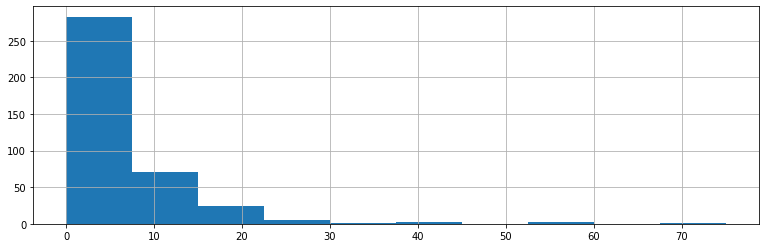

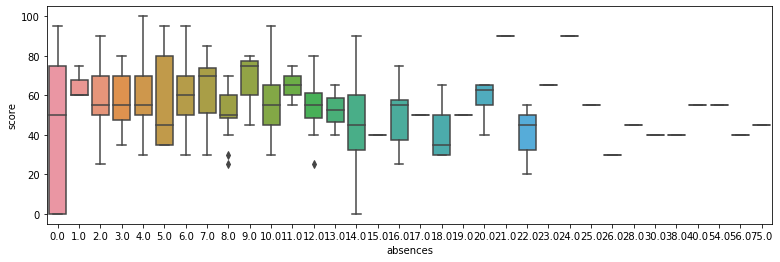

In [111]:
limits(stud_math.absences)
show_histo(stud_math.absences)
get_boxplot(stud_math.absences)

зависимости оценок от пропусков особо не замечается, очевидно что если ученик не посущал занятия хорошую оценку не получит, но и ученик без пропусков получает низкие баллы

In [182]:
info_columns(stud_math.score)
stud_math.score.describe()

Уникальные значения: 
 50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64 
 Пустые значения (кол-во): 6 
 Пустые значения (%): 1.5


count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Колонка "score", баллы по госэкзамену по математике. Данная колонка имеет 6 пустых значений (1.5%). т.к. исходя из баллов будет анализироваться зависимость/влияние всех остальных колонок на баллы ученика, считаю что здесь невозможно присвоить какое-то значение рэндомное, медианное или еще какое-либо, поэтому данные строки нужно будет удалить из анализа:

In [183]:
stud_math.dropna(subset=['score'], inplace=True)

In [184]:
info_columns(stud_math.score)
stud_math.score.describe()

Уникальные значения: 
 50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64 
 Пустые значения (кол-во): 0 
 Пустые значения (%): 0.0


count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

In [185]:
display(stud_math.head(10))
stud_math.info()

,school_number,sex_male,age,urbanite,famsize_more3,Pstatus_together,Medu,Fedu,кол-во,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,1,0,18,1.0,1.0,0.0,4.0,4.0,1,4.0,1.0,3.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,3.0,4.0,3.0,6.0,30.0
1,1,0,17,1.0,1.0,1.0,1.0,1.0,1,4.0,5.0,3.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0
2,1,0,15,1.0,0.0,1.0,1.0,1.0,1,4.0,5.0,4.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,3.0,2.0,3.0,10.0,50.0
3,1,0,15,1.0,1.0,1.0,4.0,2.0,1,2.0,5.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,2.0,75.0
4,1,0,16,1.0,1.0,1.0,3.0,3.0,1,5.0,5.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,1,1,16,1.0,0.0,1.0,4.0,3.0,1,3.0,5.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
6,1,1,16,1.0,0.0,1.0,2.0,2.0,1,5.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0,4.0,3.0,0.0,55.0
7,1,0,17,1.0,1.0,0.0,4.0,4.0,1,5.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,4.0,1.0,6.0,30.0
8,1,1,15,1.0,0.0,0.0,3.0,2.0,1,3.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,5.0,2.0,2.0,1.0,0.0,95.0
9,1,1,15,1.0,1.0,1.0,3.0,4.0,1,5.0,5.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
school_number       389 non-null int64
sex_male            389 non-null int64
age                 389 non-null int64
urbanite            389 non-null float64
famsize_more3       389 non-null float64
Pstatus_together    389 non-null float64
Medu                389 non-null float64
Fedu                389 non-null float64
кол-во              389 non-null int64
Mjob                389 non-null float64
Fjob                389 non-null float64
reason              389 non-null float64
guardian            389 non-null float64
traveltime          389 non-null float64
studytime           389 non-null float64
failures            389 non-null float64
schoolsup           389 non-null float64
famsup              389 non-null float64
paid                389 non-null float64
activities          389 non-null float64
nursery             389 non-null float64
higher              389 non-null float64
i

Первичная обработка проведена: Общее количество колонок-признаков 30, 27 номинативные и 3 числовых ('age','absences','score'). Все номинативные значения были заменены на числовые, для дальнейшего анализа. Для каждой отдельной колонки были использованы различные методы замены NaN, исходя из зависимости от тех или иных фаткоров. Доля пропусков составила не более 10%. Была удалена колонка "studytime granular", тк она коррелировалась с колонкой "studytime" и была избыточной. Были удалены строки, где пропущено значение score, т.к. восстанавливать целевое значение не корректно и данных пропусков всего 1.5% от общей доли значений. Имеется значение 0 у колонки "score", вероятно это ученики не набравшие минимальные баллы либо пропустили экзамен. Осталось 29 колонок и 389 записей


# Корреляционный анализ данных

In [186]:
#проведем корреляционный анализ количественных переменных

stud_math[['age','absences','score']].corr()

,age,absences,score
age,1.000000,0.186277,-0.155726
absences,0.186277,1.000000,0.029796
score,-0.155726,0.029796,1.000000


из корреляции видно что статистически значима только колонка, отображающая возраст ученика, чем старше ученик тем ниже вероятность получить высокие баллы в среднем

In [188]:
#Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. 
#Проверим нулевую гипотезу о том, что распределения оценок учеников по различным параметрам неразличимы:

for col in ['school_number', 'sex_male', 'urbanite', 'famsize_more3', 'Pstatus_together', 'Medu',
            'Fedu','Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime','failures',
            'schoolsup','famsup', 'paid', 'activities', 'nursery','higher','internet','romantic',
            'famrel','freetime','goout', 'health']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки urbanite
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Как мы видим (и согласно статистическим данным и исходя из графиков выше), серьёзно отличаются 9 параметров,: urbanite,  Medu и Mjob, failures, paid, higher, internet, romantic и age, которые, возможно, оказывают влияние на экзаменационную оценку учеников. Оставим эти переменные в датасете для дальнейшего построения модели.

In [113]:
stud_math_for_model = stud_math.loc[:, ['urbanite', 'Medu', 'Mjob', 'failures', 'paid',
                                        'higher', 'internet', 'romantic', 'age', 'score']]
stud_math_for_model.head()

,urbanite,Medu,Mjob,failures,paid,higher,internet,romantic,age,score
0,1.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,18,30.0
1,1.0,1.0,4.0,0.0,0.0,1.0,1.0,0.0,17,30.0
2,1.0,1.0,4.0,3.0,1.0,1.0,1.0,0.0,15,50.0
3,1.0,4.0,2.0,0.0,1.0,1.0,1.0,1.0,15,75.0
4,1.0,3.0,5.0,0.0,1.0,1.0,0.0,0.0,16,50.0


# В результате анализа влияния условий жизни учеников на успеваемость по математике (а именно, на финальный экзамен) были получены следующие выводы:
## В данных достаточно мало пустых значений, менее 11%
## В данных много номинативных признаков, которые имели четкие границы и варианты ответов, что значительно сократило количество выбросов. Данные достаточно чистые.
## В значимых колонках (баллы учеников) имелись пустые значения, которые пришлось исключить из анализа, исключение составило только 1.5%;
## Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'urbanite', 'Medu', 'Mjob', 'failures', 'paid', 'higher', 'internet', 'romantic', 'age', 'score'.
